In [1]:
%matplotlib inline


# Cognitive Load Classification

ensure Pytorch and Torchaudio is installed.


In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
import torch.optim as optim
import torchaudio
import numpy as np
import sys, os

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

import random

Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Importing the Dataset

If you haven't down AVCAffe dataset, please refer to
[AVCAffe](https://github.com/pritamqu/AVCAffe), data structure can be seen from [Arxiv](https://arxiv.org/abs/2205.06887).
This notebook is based on Pytorch's [speech_command_classification_with_torchaudio](https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html)

The data loader in this git is modified for the BioPhysics project.




set dataset directory


In [4]:
PROJECT_PATH = os.getcwd()
AVCAFFE_PATH =  os.path.join(PROJECT_PATH, "AVCAffe")
print(PROJECT_PATH)

/home/hushouyue0928/CLAudioFeatures


load dataset for train and test

In [5]:
random.seed(0)

os.chdir(os.path.join(AVCAFFE_PATH, "codes","dataloader"))
from AVCAffe.codes.dataloader.avcaffe_vid import AVCAffe
os.chdir(PROJECT_PATH)

DB_PATH = os.path.join(AVCAFFE_PATH, "data")
shorter_segments = os.path.join(DB_PATH, 'videos', 'shorter_segments')
print( "audio segment list:", os.listdir( shorter_segments) )

sample_rate = 8000
sample_rate_orig = 16000
duration = 1.

train_set = AVCAffe(DB_PATH,
             subset='train',
             return_video=False,
             video_clip_duration=duration,
             video_fps=16.,
             return_audio=True,
             audio_clip_duration=duration,
             audio_fps=sample_rate_orig,
             return_labels=True,
             audio_must=True,
             cogload_class_type='4-tier',
             class_name='mental_demand',
             mode='clip',
             clips_per_video=1,
             )
print('loaded', len(train_set), '\ttrain')

val_set = AVCAffe(DB_PATH,
             subset='val',
             return_video=False,
             video_clip_duration=duration,
             video_fps=16.,
             return_audio=True,
             audio_clip_duration=duration,
             audio_fps=sample_rate_orig,
             return_labels=True,
             audio_must=True,
             cogload_class_type='4-tier',
             class_name='mental_demand',
             mode='clip',
             clips_per_video=1,
             )
print('loaded', len(val_set), '\tvalidation')


audio segment list: ['aiim104', 'aiim072', 'aiim021', 'aiim079', 'aiim008', 'aiim076', 'aiim052', 'aiim107', 'aiim020', 'aiim033', 'aiim006', 'aiim059', 'aiim030', 'aiim012', 'aiim047', 'aiim100', 'aiim081', 'aiim040', 'aiim049', 'aiim001', 'aiim080', 'aiim073', 'aiim068', 'aiim057', 'aiim027', 'aiim064', 'aiim023', 'aiim102', 'aiim062', 'aiim077', 'aiim032', 'aiim038', 'aiim089', 'aiim010', 'aiim042', 'aiim014', 'aiim098', 'aiim031', 'aiim029', 'aiim011', 'aiim106', 'aiim056', 'aiim066', 'aiim083', 'aiim025', 'aiim024', 'aiim063', 'aiim044', 'aiim065', 'aiim087', 'aiim009', 'aiim022', 'aiim002', 'aiim013', 'aiim034', 'aiim019', 'aiim055', 'aiim037', 'aiim082', 'aiim054', 'aiim046', 'aiim017', 'aiim084', 'aiim070', 'aiim088', 'aiim071', 'aiim075', 'aiim078', 'aiim028', 'aiim061', 'aiim095', 'aiim091', 'aiim048', 'aiim092', 'aiim060', 'aiim085', 'aiim005', 'aiim043', 'aiim108', 'aiim039', 'aiim036', 'aiim090', 'aiim067', 'aiim074', 'aiim058', 'aiim105', 'aiim103', 'aiim050', 'aiim069', 

Preview the first waveform from dataset (the audio signal) and it's corresponding label




1 
 [-6.10370190e-05 -3.05185095e-05  0.00000000e+00 ...  2.13629566e-04
  1.83111057e-04  1.83111057e-04]


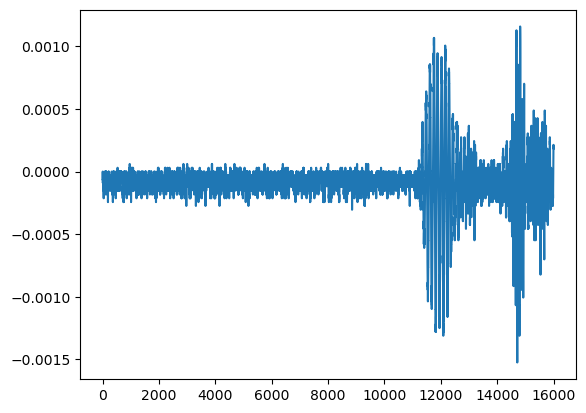

In [6]:
example = train_set[0]
print(example['label'],'\n',example['audio'][0])
plt.plot(example['audio'][0])

The 35 audio labels are commands that are said by users. The first few
files are people saying “marvin”.

set labels list

In [7]:
labels = [i for i in range(4)]
print(labels)

[0, 1, 2, 3]


define audio wave transformation function

In [8]:
waveform_first = train_set[0]['audio']
resample = torchaudio.transforms.Resample(orig_freq=sample_rate_orig, new_freq=sample_rate)


n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 40

transform = T.MFCC(
    sample_rate=sample_rate_orig,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)


ipd.Audio(waveform_first, rate=sample_rate)

## Formatting the Data

Helper functions




We are encoding each word using its index in the list of labels.




In [9]:
def label_to_index(label):
    # Return the position of the word in labels
    return torch.tensor(labels.index(label))


def index_to_label(label):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[label]

label_first = train_set[0]['label']
index = label_to_index(label_first)
label_recovered = index_to_label(index)

print(label_first, "-->", index, "-->", label_recovered)

1 --> tensor(1) --> 1


To turn a list of data point made of audio recordings and utterancesinto two batched tensors for the model, we implement a collate functionwhich is used by the PyTorch DataLoader that allows us to iterate over adataset by batches. Please see [the documentation](https://pytorch.org/docs/stable/data.html#working-with-collate-fn) for more information about working with a collate function.

resampling, and the textencoding.




In [10]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    # batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for i in range(len(batch)):
        waveform = torch.from_numpy(batch[i]['audio']).t()
        # print("waveform:",waveform.size())
        tensors += [waveform]
        targets += [label_to_index(batch[i]['label'])]
    

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 512

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Define the Network

The specific architecture is modeled after the M5 network architecture
described in [this paper](https://arxiv.org/pdf/1610.00087.pdf)_. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [11]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


# model = M5(n_input=n_mfcc, n_output=len(labels))
model = M5(n_input=waveform_first.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=4, bias=True)
)
Number

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.001, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [12]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

## Training and Testing the Network

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [13]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device,dtype=torch.float)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = resample(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [14]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device,dtype=torch.float)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = resample(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        loss = F.nll_loss(output.squeeze(), target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\tLoss: {loss.item():.6f}\n")

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




In [15]:
# for i in range(len(train_set)):
#     a = train_set[i]['audio']
#     if a.shape[0]!=1 or a.shape[1]!=8000:
#         print("no", a.shape)

In [16]:
log_interval = 20
n_epoch = 30

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
resample = resample.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()


  0%|          | 0/30 [00:00<?, ?it/s]/home/hushouyue0928/mambaforge/envs/claudio/lib/python3.11/site-packages/torchaudio/functional/functional.py:1551: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  resampled = torch.nn.functional.conv1d(waveform[:, None], kernel, stride=orig_freq)
  0%|          | 0.0016207455429497568/30 [00:01<6:55:19, 830.71s/it]

Train Epoch: 1 [0/32296 (0%)]	Loss: 1.574923


  0%|          | 0.025931928687196112/30 [00:15<5:03:42, 607.94s/it] 

save model to file

In [ ]:
import pickle as pkl

epoch_trained = 30
#to save it
with open(f"epoch/model_epoch_{epoch_trained}.pkl", "wb") as f:
    pkl.dump(model, f)

#to load it
with open(f"epoch/model_epoch_{epoch_trained}.pkl", "rb") as f:
    model = pkl.load(f)

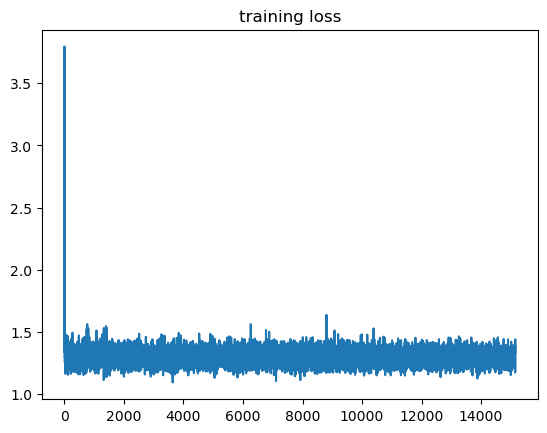

In [ ]:

# Let's plot the training loss versus the number of iteration.
plt.plot(losses);
plt.title("training loss");

In [ ]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device, dtype=torch.float)
    tensor = resample(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform = torch.from_numpy(train_set[-1]['audio'])
utterance = train_set[-1]['label']
ipd.Audio(train_set[-1]['audio'], rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: 1. Predicted: 2.


Find an example that isn’t classified correctly, if there is one.




In [ ]:
for i, row in enumerate(val_set):
    waveform = torch.from_numpy(train_set[-1]['audio'])
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

Data point #0. Expected: 1. Predicted: 2.


test with your voice using Google Colab audio recorder



In [ ]:
def record(seconds=1):

    from google.colab import output as colab_output
    from base64 import b64decode
    from io import BytesIO
    from pydub import AudioSegment

    RECORD = (
        b"const sleep  = time => new Promise(resolve => setTimeout(resolve, time))\n"
        b"const b2text = blob => new Promise(resolve => {\n"
        b"  const reader = new FileReader()\n"
        b"  reader.onloadend = e => resolve(e.srcElement.result)\n"
        b"  reader.readAsDataURL(blob)\n"
        b"})\n"
        b"var record = time => new Promise(async resolve => {\n"
        b"  stream = await navigator.mediaDevices.getUserMedia({ audio: true })\n"
        b"  recorder = new MediaRecorder(stream)\n"
        b"  chunks = []\n"
        b"  recorder.ondataavailable = e => chunks.push(e.data)\n"
        b"  recorder.start()\n"
        b"  await sleep(time)\n"
        b"  recorder.onstop = async ()=>{\n"
        b"    blob = new Blob(chunks)\n"
        b"    text = await b2text(blob)\n"
        b"    resolve(text)\n"
        b"  }\n"
        b"  recorder.stop()\n"
        b"})"
    )
    RECORD = RECORD.decode("ascii")

    print(f"Recording started for {seconds} seconds.")
    display(ipd.Javascript(RECORD))
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return torchaudio.load(filename)


# Detect whether notebook runs in google colab
if "google.colab" in sys.modules:
    waveform, sample_rate = record()
    print(f"Predicted: {predict(waveform)}.")
    ipd.Audio(waveform.numpy(), rate=sample_rate)

## Conclusion

We used torchaudio to load a dataset and resample the
signal. We have then defined a neural network that we trained to
recognize a given command. There are also other data preprocessing
methods, such as finding the mel frequency cepstral coefficients (MFCC),
that can reduce the size of the dataset. This transform is also
available in torchaudio as ``torchaudio.transforms.MFCC``.


